### <a href ='https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html'> Predicting Boston House Price </a>

In [4]:
# %load load_packages.py
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import warnings
from random import randint
from tensorflow.keras import optimizers
from dominance_analysis import Dominance_Datasets
from sklearn.model_selection import train_test_split

warnings.filterwarnings(action='ignore')

def print_package_versions(log_flag=False):
    if(log_flag):
        print("Tensorflow Version :",tf.__version__)
        print("Pandas Version :",pd.__version__)
        print("Numpy Version :",np.__version__)
        print("Keras Version :",keras.__version__)
        print("OpenCV Version :",cv2.__version__)
    else:
        pass

print_package_versions(True)


Loading BokehJS ...

Tensorflow Version : 1.13.1
Pandas Version : 0.23.4
Numpy Version : 1.15.4
Keras Version : 2.2.4-tf
OpenCV Version : 4.1.0


In [5]:
boston_dataset=Dominance_Datasets.get_boston()

The copy of Boston Housing Dataset is downloaded from: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html
Internally using load_boston function from sklearn.datasets 


In [6]:
boston_dataset.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,House_Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


There are 14 attributes in each case of the dataset. They are:

1. CRIM - per capita crime rate by town
2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS - proportion of non-retail business acres per town.
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centres
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per \$10,000
11. PTRATIO - pupil-teacher ratio by town
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT - \% lower status of the population
14. House_Price - Median value of owner-occupied homes in $1000's

In [9]:
boston_dataset.isna().sum()

CRIM           0
ZN             0
INDUS          0
CHAS           0
NOX            0
RM             0
AGE            0
DIS            0
RAD            0
TAX            0
PTRATIO        0
B              0
LSTAT          0
House_Price    0
dtype: int64

### Split the data into train and test

In [10]:
from sklearn.utils import shuffle

In [16]:
boston_dataset=shuffle(boston_dataset)
train_dataset = boston_dataset.sample(frac=0.8,random_state=42)
test_dataset = boston_dataset.drop(train_dataset.index)

In [17]:
train_dataset.shape,test_dataset.shape

((405, 14), (101, 14))

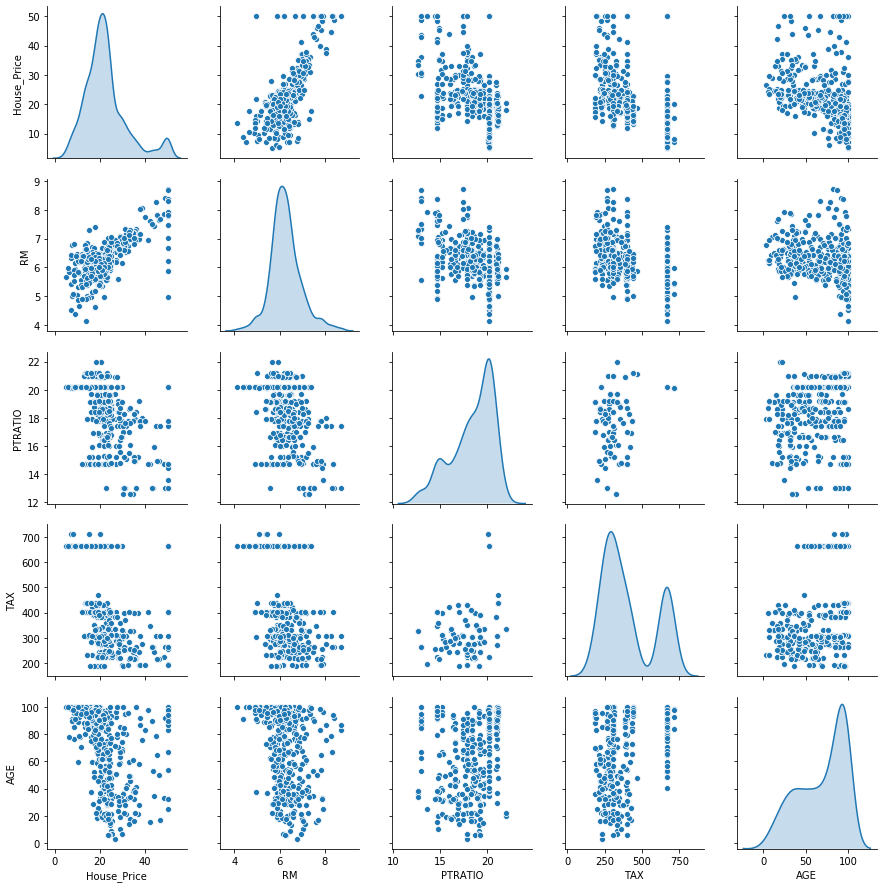

In [19]:
sns.pairplot(train_dataset[["House_Price", "RM", "PTRATIO", "TAX",'AGE']], diag_kind="kde")

In [20]:
train_stats = train_dataset.describe()
train_stats.pop("House_Price")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
CRIM,405.0,3.469401,7.724510,0.00632,0.0795,0.26838,3.69311,73.5341
ZN,405.0,11.427160,23.779156,0.00000,0.0000,0.00000,12.50000,100.0000
INDUS,405.0,11.224123,6.896373,0.46000,5.1900,9.69000,18.10000,27.7400
CHAS,405.0,0.069136,0.253999,0.00000,0.0000,0.00000,0.00000,1.0000
NOX,405.0,0.555890,0.113282,0.38900,0.4530,0.53800,0.62400,0.8710
RM,405.0,6.271188,0.668273,4.13800,5.8770,6.20900,6.59500,8.7250
AGE,405.0,69.158272,27.794084,2.90000,45.8000,77.70000,94.60000,100.0000
DIS,405.0,3.785167,2.125779,1.12960,2.1000,3.13230,5.11800,12.1265
RAD,405.0,9.597531,8.741530,1.00000,4.0000,5.00000,24.00000,24.0000
TAX,405.0,409.683951,169.114756,187.00000,281.0000,335.00000,666.00000,711.0000


In [21]:
train_labels = train_dataset.pop('House_Price')
test_labels = test_dataset.pop('House_Price')

In [22]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [25]:
def build_model():
    model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [26]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [28]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.7135368 ],
       [0.3551054 ],
       [0.03477488],
       [0.06802772],
       [0.24784751],
       [1.3809522 ],
       [1.2475524 ],
       [0.78023684],
       [0.7957616 ],
       [0.6834473 ]], dtype=float32)

In [29]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

In [30]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,0.447840,0.480545,0.447840,15.110185,2.914125,15.110185,995
996,0.494145,0.515223,0.494145,16.557999,2.948496,16.557999,996
997,0.465753,0.513748,0.465753,14.990386,2.874968,14.990385,997
998,0.565237,0.562823,0.565237,16.164871,3.020528,16.164871,998
999,0.455417,0.515272,0.455417,15.056097,2.831087,15.056097,999


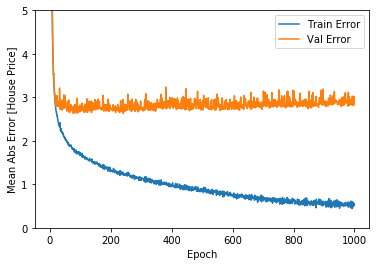

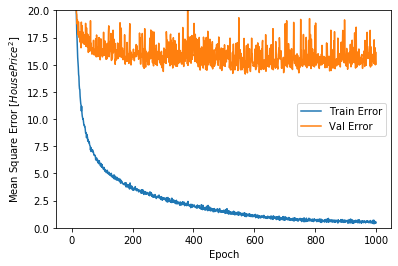

In [32]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [House Price]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$House Price^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)


.............................................

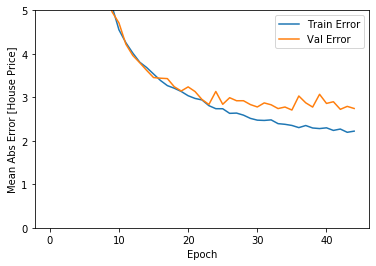

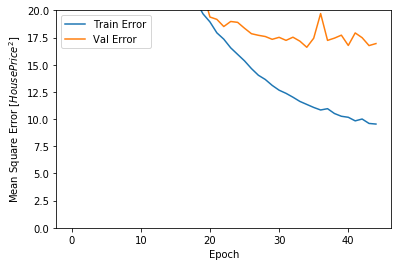

In [33]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [35]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} House Price".format(mae))

Testing set Mean Abs Error:  2.83 House Price


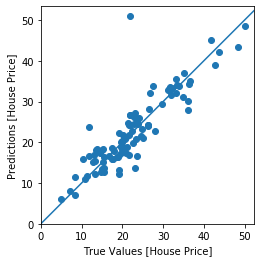

In [36]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [House Price]')
plt.ylabel('Predictions [House Price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])